In [2]:
%cd ..

c:\Users\YbII Cobra\Documents\YbII


In [883]:
import numpy as np
import matplotlib.pyplot as plt

# Fitting Module
import lmfit
from lmfit.models import gaussian2d

# Image Processing Module
import imageio
import matplotlib.pyplot as plt

from src.functions.math import func as mathf
from src.functions.optics import func as optf
from src.constants import const

# p is the measured power per beam before any VP, w1 and w2 are the beam waist radii
# s0 = 3 * (I_0 * T + I_0 * T ** 3) / I_sat
# def get3DMOTS0(p, w1=2.77e-3, w2=2.64e-3): # before 06/18/24; we now use the newly measured waists 
def get3DMOTS0(p, w=3e-3):
    return 3 * p / (np.pi * w ** 2 / 2) * (0.955 + 0.955 ** 3) / const.Is_1s0_1p1

# probability of the atom being in the excited state (from Eva Casotti's thesis)
# f is frequency on the wavemeter
# p is the measured power per beam before any VP
# 3D MOT is 10 MHZ more blue than 2D MOT at the same wavemeter frequency due to AOM freq difference
def rho3DMOT(f, p):
    # w_atom = const.w0_1s0_1p1_32
    # w_l = f + 
    return get3DMOTS0(p) / 2 / (1 + get3DMOTS0(p) + (2 * (2 * np.pi * f + 2 * np.pi * 10e6 - const.w0_1s0_1p1_32) / const.gamma_1s0_1p1) ** 2)

# sum up the pixel values in the region of interest
# x0, y0, wx, wy are the parameters of the Gaussian fit
# img_res is the background-subtracted image data
# f is frequency of the cooling beam
# p is the measured power per beam before any VP
# d0 is the image distance from the MOT to the first lens
def get3DMOTAtomNumber(x0, y0, box_x, box_y, img, t_exp, f, p, d0):
    x0 = int(x0)
    y0 = int(y0)
    box_x = int(box_x)
    box_y = int(box_y)
    I_sum = np.sum(img[y0-box_y:y0+box_y, x0-box_x:x0+box_x])
    print(I_sum)
    QE399 = 0.42 # quantum efficiency of the camera for 399 nm light
    QE399_chroma = 0.17 # quantum efficiency of the camera for 399 nm light of (acA3800-14uc) chroma cam
    # ppi = 2800 / QE399 / 255 # photon per pixel per intensity
    ppi = 2800 / QE399 / 255 # photon per pixel per intensity
    eff = (0.0254/2) ** 2 / 4 / d0 ** 2 # collection efficiency of the imaging setup, assuming using 1 inch lens
    gamma_tot = I_sum * ppi / eff / t_exp # total photon emission rate
    gamma_atom = const.gamma_1s0_1p1 * rho3DMOT(f, p) # photon emission rate of a single atom
    print(rho3DMOT(f, p))
    return gamma_tot / gamma_atom

# get the number of imaged atoms
# img is the MOT image data, img_bg is the background image data
# t_exp is the exposure time of the camera
# f is frequency of the cooling beam
# p is the measured power per beam before any VP
def getImaged3DMOTAtomNumber(img, img_bg, t_exp, f, p, d0):
    x_rg = np.arange(0, img.shape[1])
    y_rg = np.arange(0, img.shape[0])

    img_res = np.abs(np.array(img, dtype=float) - np.array(img_bg, dtype=float))
    img_res = (np.array(img, dtype=float) - np.array(img_bg, dtype=float))
    img_res[img_res < 0] = 0
    img_res = img
    # img_res[img_res < np.max(img_res) * 0.10] = 0
    x_data = np.max(img_res, axis=0)
    y_data = np.max(img_res, axis=1)

    # also in /src/functions/math/func.py
    def GaussianWBaseline(x, center, sigma, amplitude, c_c):
        return amplitude * np.exp(-((x - center) ** 2) / (2 * sigma ** 2)) + c_c

    model = lmfit.Model(GaussianWBaseline)

    # adjust the initial parameters if needed
    params_x = model.make_params(c_c=0, center=np.argmax(x_data), sigma=50, amplitude=np.max(x_data))
    params_y = model.make_params(c_c=0, center=np.argmax(y_data), sigma=50, amplitude=np.max(y_data))

    # Set constraints if needed
    # params_x['sigma'].set(max=150)
    # params_x['sigma'].set(min=50)
    # params_y['sigma'].set(max=150)
    # params_y['sigma'].set(min=50)
    params_x['amplitude'].set(min=100)
    params_y['amplitude'].set(min=100)
    params_x['center'].set(min=1500)
    params_x['center'].set(max=2000)
    params_y['center'].set(min=1500)
    params_y['center'].set(max=2100)
    params_x['c_c'].set(max=50)
    params_y['c_c'].set(max=50)

    result_x = model.fit(x_data, params_x, x=x_rg)
    result_y = model.fit(y_data, params_y, x=y_rg)

    x_fit = result_x.best_fit
    y_fit = result_y.best_fit

    x0 = result_x.best_values['center']
    y0 = result_y.best_values['center']

    x0 = 1400
    y0 = 1500

    wx = 2 * result_x.best_values['sigma']
    # dwx = 2 * result_x.params['sigma'].stderr
    dwx = 0
    wy = 2 * result_y.best_values['sigma']
    # dwy = 2 * result_y.params['sigma'].stderr
    dwy = 0
    # print("2DMOT Diameter:", 4 * 2 * wy * 1.67 * 10**(-3))
    # wx = wx / 2
    # wy = wy / 2
    box_x=250
    box_y=250

    for param_name, param in result_x.params.items():
        print(f"Parameter: {param_name}, Error: {param.stderr}")
    #     print(param)


    return img_res, x0, y0, wx, wy, dwx, dwy, x_data, x_fit, y_data, y_fit, box_x, box_y, get3DMOTAtomNumber(x0, y0, box_x, box_y, img_res, t_exp, f, p, d0)

# plot the image data along with the Gaussian fit and the atom number
# img is the MOT image data, img_bg is the background image data
# t_exp is the exposure time of the camera
# f is the laser frequency in angular frequency units
# p is the measured power per beam before any VP
def plot3DMOTNumber(img, img_bg, t_exp, f, p, d0):
    m = 1/4
    pixel_to_mm = 1.67 * 10**(-3)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    x_rg = np.arange(0, img.shape[1])
    y_rg = np.arange(0, img.shape[0])

    img_res, x0, y0, wx, wy, dwx, dwy, x_data, x_fit, y_data, y_fit, box_x, box_y, atom_num = getImaged3DMOTAtomNumber(img, img_bg, t_exp, f, p, d0)

    axs[0].imshow(img_res, cmap='gray')

    axs[0].set_xlim([0, img.shape[1]])
    axs[0].set_ylim([0, img.shape[0]])
    axs[0].set_xlabel('Pixel')
    axs[0].set_ylabel('Pixel')

    axs[0].hlines(y0-box_y, x0-box_x, x0+box_x, color='b', linestyles='dashed')
    axs[0].hlines(y0+box_y, x0-box_x, x0+box_x, color='b', linestyles='dashed')
    axs[0].vlines(x0-box_x, y0-box_y, y0+box_y, color='r', linestyles='dashed')
    axs[0].vlines(x0+box_x, y0-box_y, y0+box_y, color='r', linestyles='dashed')

    axs[1].scatter(x_rg, x_data)
    axs[1].plot(x_rg, x_fit, 'r', label='x Fit')
    axs[1].scatter(y_rg, y_data)
    axs[1].plot(y_rg, y_fit, 'b', label='y Fit')
    axs[1].vlines(x0-box_x, 0, 100, color='r', linestyles='dashed', label='x bounds')
    axs[1].vlines(x0+box_x, 0, 100, color='r', linestyles='dashed')
    axs[1].vlines(y0-box_y, 0, 100, color='b', linestyles='dashed', label='y bounds')
    axs[1].vlines(y0+box_y, 0, 100, color='b', linestyles='dashed')
    
    axs[1].set_xlabel('Pixel')
    axs[1].set_ylabel('Intensity')
    axs[1].legend()

    factor = 100

    fig.suptitle('3D MOT #Atom ~ {:.1e}'.format(atom_num) + 
                 '\n Center position: ({}, {}); Box size: ({}, {})'.format(int(x0), int(y0), box_x * 2, box_y * 2) + 
                 '\n Fitted waists: (wx={}({}) mm,  wy={}({}) mm)'.format(round(wx / m * pixel_to_mm, 2),int(round(dwx * factor / m * pixel_to_mm, 0)),round(wy / m * pixel_to_mm, 2), int(round(dwy * factor / m * pixel_to_mm, 0))))
    return atom_num

C:\Users\YbII Cobra\AppData\Local\Temp\ipykernel_27928\663652545.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot3DMOTNumber(imageio.imread(r'C:\Users\YbII Cobra\Desktop\3D MOT\\0620\G step\I_93_1_A_t_2765_0_us_ph1_35_1_mw_ph2_36_0_mw_pvert_2_6_mw.bmp'), imageio.imread(r'C:\Users\YbII Cobra\Desktop\3D MOT\\0620\G step\I_93_1_A_t_2765_0_us_ph1_35_1_mw_ph2_36_0_mw_pvert_2_6_mw.bmp'), 2765e-6, 751.5270397e12, 24.6e-3, 19.5e-2)


Parameter: center, Error: 8.109415598965333e-12
Parameter: sigma, Error: 1.0529746035832641
Parameter: amplitude, Error: 4.070320901271624
Parameter: c_c, Error: 0.5211754739483152
13996725
0.2621693280388057


2603555.7917654794

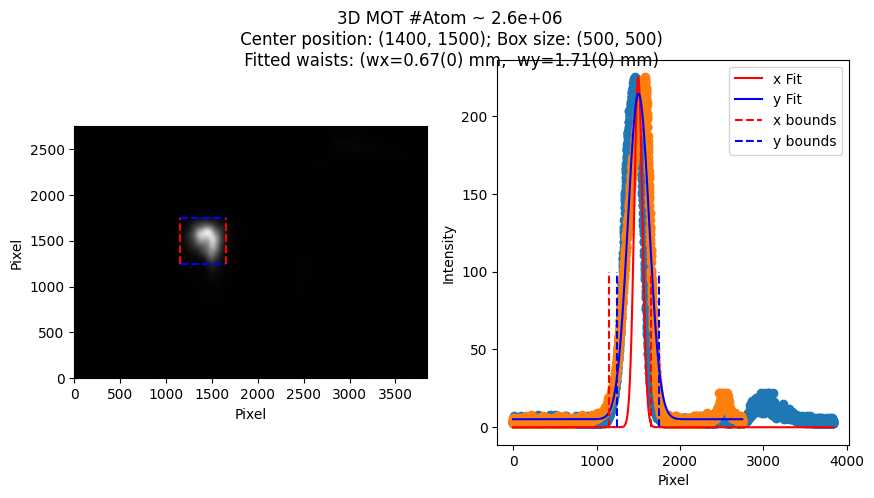

In [882]:
plot3DMOTNumber(imageio.imread(r'C:\Users\YbII Cobra\Desktop\3D MOT\\0620\G step\I_93_1_A_t_2765_0_us_ph1_35_1_mw_ph2_36_0_mw_pvert_2_6_mw.bmp'), imageio.imread(r'C:\Users\YbII Cobra\Desktop\3D MOT\\0620\G step\I_93_1_A_t_2765_0_us_ph1_35_1_mw_ph2_36_0_mw_pvert_2_6_mw.bmp'), 2765e-6, 751.5270397e12, 24.6e-3, 19.5e-2)

C:\Users\YbII Cobra\AppData\Local\Temp\ipykernel_27928\3686573608.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot3DMOTNumber(imageio.imread(r'C:\Users\YbII Cobra\Desktop\3D MOT\0619\v steps\vy steps\t_1820_0_us_vx_0_vy_45_iris_12_0.bmp'), imageio.imread('C:\\Users\\YbII Cobra\\Desktop\\3D MOT\\0611\\t=1355550us_p_{s,l,v}=17.9,16.3,0.075mw_wo_backreflection_hwp=58_vcoil=2.1_bg.bmp'), 1820e-6, 751.5270397e12, 24.7e-3, 19.5e-2)


Parameter: center, Error: 0.308034479180727
Parameter: sigma, Error: 0.31501031404705987
Parameter: amplitude, Error: 0.6883231679434659
Parameter: c_c, Error: 0.11938162360663815
12257380
0.262675175922183


3457201.6031695814

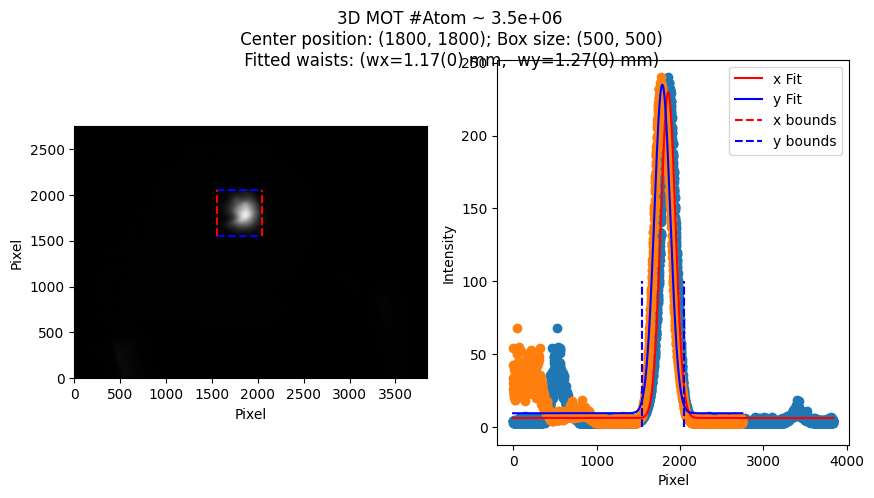

In [871]:
plot3DMOTNumber(imageio.imread(r'C:\Users\YbII Cobra\Desktop\3D MOT\0619\v steps\vy steps\t_1820_0_us_vx_0_vy_45_iris_12_0.bmp'), imageio.imread('C:\\Users\\YbII Cobra\\Desktop\\3D MOT\\0611\\t=1355550us_p_{s,l,v}=17.9,16.3,0.075mw_wo_backreflection_hwp=58_vcoil=2.1_bg.bmp'), 1820e-6, 751.5270397e12, 24.7e-3, 19.5e-2)
